<a href="https://colab.research.google.com/github/HumailShahzad/M5_Forecasting/blob/main/M5Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px
import pandas as pd


In [ ]:
def plot_bar(data, title, xlabel, ylabel, figsize=(10, 5), rotation=45, palette="viridis"):
    plt.figure(figsize=figsize)
    sns.barplot(x=data.index, y=data.values, palette=palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()


In [ ]:
# Load datasets
sales = pd.read_csv('sales_train_validation.csv')
calendar = pd.read_csv('calendar.csv')
sell_prices = pd.read_csv('sell_prices.csv')
# Preprocess calendar
date_cols = ['date']
calendar[date_cols] = calendar[date_cols].apply(pd.to_datetime)


In [ ]:
# Filter data to only include CA state and CA_1 store
sales = sales[(sales['state_id'] == 'CA') & (sales['store_id'] == 'CA_1')]

In [ ]:
# Melt sales data to long format so each row is one day of sales for an item
sales_long = pd.melt(sales,
                     id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                     var_name='d', value_name='sales')
# Merge with calendar to get real dates and event information
sales_long = sales_long.merge(calendar[['d', 'date', 'weekday','month', 'event_name_1', 'event_type_1','event_name_2','snap_CA']], on='d', how='left')
sales_long['week'] = sales_long['date'].dt.isocalendar().week
sales_long.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5832737 entries, 0 to 5832736
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       object        
 2   dept_id       object        
 3   cat_id        object        
 4   store_id      object        
 5   state_id      object        
 6   d             object        
 7   sales         int64         
 8   date          datetime64[ns]
 9   weekday       object        
 10  month         int64         
 11  event_name_1  object        
 12  event_type_1  object        
 13  event_name_2  object        
 14  snap_CA       int64         
 15  week          UInt32        
dtypes: UInt32(1), datetime64[ns](1), int64(3), object(11)
memory usage: 695.3+ MB


In [ ]:
### ---- 1. Top 10 Products Sold by Categories ---- ###

for category in sales_long['cat_id'].unique():
    top_cat_products = (
        sales_long[sales_long['cat_id'] == category]
        .groupby('item_id')['sales']
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )
    plot_bar(
        top_cat_products,
        title=f"Top 10 Products in Category: {category}",
        xlabel="Item ID",
        ylabel="Total Sales",
        palette="mako"
    )
### ---- 1. Top 10 Products Sold by Department ---- ###

for department in sales_long['dept_id'].unique():
    top_cat_products = (
        sales_long[sales_long['dept_id'] == department]
        .groupby('item_id')['sales']
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )
    plot_bar(
        top_cat_products,
        title=f"Top 10 Products in Department: {department}",
        xlabel="Item ID",
        ylabel="Total Sales",
        palette="mako"
    )

top_products = sales_long.groupby('item_id')['sales'].sum().sort_values(ascending=False).head(10)
plot_bar(top_products, "Top 10 Products by Total Sales in (CA_1 Store)", "Item ID", "Total Sales")

### ---- 2. Simulated Reordered Products (Weekly) ---- ###

weekly_sales = sales_long.groupby(['item_id', 'week'])['sales'].sum().reset_index()
weekly_sales['reordered'] = (weekly_sales['sales'] > 0).astype(int)
reorder_rate = weekly_sales.groupby('item_id')['reordered'].mean().sort_values(ascending=False).head(20)
plot_bar(reorder_rate, "Top 20 Items by Weekly Reorder Rate", "Item ID", "Reorder Rate", palette="coolwarm")

### ---- Reordered Products (Monthly)
monthly_sales = sales_long.groupby(['item_id', 'month'])['sales'].sum().reset_index()
monthly_sales['reordered'] = (monthly_sales['sales'] > 0).astype(int)
reorder_rate = monthly_sales.groupby('item_id')['reordered'].mean()
total_sales = monthly_sales.groupby('item_id')['sales'].sum()

# --- 3. Merge into a single DataFrame ---
reorder_df = pd.DataFrame({
    'reorder_rate': reorder_rate,
    'total_sales': total_sales
}).sort_values('reorder_rate', ascending=False).head(20).reset_index()

# --- 4. Create interactive bar chart with Plotly ---
fig = px.bar(
    reorder_df,
    x='item_id',
    y='reorder_rate',
    color='total_sales',
    color_continuous_scale='Bluered_r',
    hover_data={'total_sales': True, 'reorder_rate': ':.2f', 'item_id': False},
    labels={'item_id': 'Item ID', 'reorder_rate': 'Reorder Rate', 'total_sales': 'Total Sales'},
    title='🔁 Top 20 Items by Monthly Reorder Rate (Color = Total Sales)'
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

### ---- 3. Top Departments by Reordered Products ---- ###
dept_sales = sales_long.groupby('dept_id')['sales'].sum().sort_values(ascending=False)
plot_bar(dept_sales, "Total Sales by Department", "Department", "Total Sales", figsize=(8, 5), palette="Set2")

### ---- 4. Orders (Sales) by Day of the Week ---- ###
dow_sales = sales_long.groupby('weekday')['sales'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plot_bar(dow_sales, "Total Sales by Day of Week", "Day of Week", "Sales", palette="pastel")

for cat in ['FOODS', 'HOUSEHOLD', 'HOBBIES']:
    series = sales_long[sales_long['cat_id'] == cat].groupby('date')['sales'].sum()
    series.plot(label=cat)
plt.legend()
plt.title("Category-wise Daily Sales")
plt.show()


In [ ]:
### ---- 5. General Trend & Seasonality (Example Product) ---- ###
example_item = sales_long[sales_long['item_id'] == top_products.index[0]]
daily_series = example_item.groupby('date')['sales'].sum()
# Seasonal decomposition
decomp = seasonal_decompose(daily_series, model='additive', period=365)
decomp.plot()
plt.suptitle(f"Trend/Seasonality for Top Product: {top_products.index[0]}", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Rolling average for general trend
plt.figure(figsize=(12, 4))
daily_series.rolling(window=30).mean().plot(label='30-day Rolling Mean')
daily_series.plot(alpha=0.4, label='Raw Sales')
plt.title(f"Trend of {top_products.index[0]} with 30-day Rolling Average")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
### ---- 6. Basic Feature Engineering ---- ###
sales_long = sales_long.sort_values(['id', 'date'])
sales_long['lag_7'] = sales_long.groupby('id')['sales'].shift(7)
sales_long['rolling_mean_30'] = sales_long.groupby('id')['sales'].shift(1).rolling(30).mean()
sales_long['rolling_std_30'] = sales_long.groupby('id')['sales'].shift(1).rolling(30).std()

In [ ]:
# Visualize features for a top product
fe_sample = sales_long[sales_long['item_id'] == top_products.index[0]].dropna().copy()

plt.figure(figsize=(12, 5))
plt.plot(fe_sample['date'], fe_sample['sales'], label='Sales', alpha=0.4)
plt.plot(fe_sample['date'], fe_sample['lag_7'], label='Lag 7', linestyle='--')
plt.plot(fe_sample['date'], fe_sample['rolling_mean_30'], label='Rolling Mean 30')
plt.fill_between(fe_sample['date'],
                 fe_sample['rolling_mean_30'] - fe_sample['rolling_std_30'],
                 fe_sample['rolling_mean_30'] + fe_sample['rolling_std_30'],
                 color='gray', alpha=0.2, label='Rolling Std Dev')
plt.title(f"Sales & Feature Trends for {top_products.index[0]}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()


# **Forecast**

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Step 1: Build time series for FOOD Category
cat_series = sales_long.groupby(['cat_id', 'date'])['sales'].sum().reset_index()
ts_wide = cat_series.pivot(index='date', columns='cat_id', values='sales')
ts_wide.head()

cat_id,FOODS,HOBBIES,HOUSEHOLD
date,,,
2011-01-29,3239,556,542
2011-01-30,3137,498,520
2011-01-31,2008,415,393
2011-02-01,2258,392,401
2011-02-02,2032,268,330


In [ ]:
series=ts_wide['FOODS']


In [ ]:
#plot series time series
series.plot()

In [ ]:
#check stationarity
result = adfuller(series)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Stationary ✅" if result[1] < 0.05 else "Non-stationary ❌")

In [ ]:
#Non seasonal differencing
series_diff1=series.diff().dropna()
result = adfuller(series_diff1)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Stationary ✅" if result[1] < 0.05 else "Non-stationary ❌")

In [ ]:
series_diff1.plot()

In [ ]:
series_diff2=series.diff(7).dropna()
result = adfuller(series_diff2)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Stationary ✅" if result[1] < 0.05 else "Non-stationary ❌")

In [ ]:
series_diff2.plot()

In [ ]:
# Step 6: ACF & PACF to choose ARIMA(p,d,q)
plot_acf(series_diff1, lags=30)
plot_pacf(series_diff1, lags=30)
plt.show()

**ARIMA**

In [ ]:
# Step 7: Fit ARIMA model
model = ARIMA(series, order=(4,1,2))
model_fit = model.fit()
print(model_fit.summary())
model = ARIMA(series, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferr

                               SARIMAX Results                                
Dep. Variable:                  FOODS   No. Observations:                 1913
Model:                 ARIMA(4, 1, 2)   Log Likelihood              -14077.600
Date:                Mon, 28 Jul 2025   AIC                          28169.200
Time:                        13:03:47   BIC                          28208.092
Sample:                    01-29-2011   HQIC                         28183.513
                         - 04-24-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7423      0.018     40.343      0.000       0.706       0.778
ar.L2         -0.8436      0.023    -36.526      0.000      -0.889      -0.798
ar.L3          0.0878      0.023      3.824      0.0

In [ ]:
train = series.iloc[:-60]
test = series.iloc[-60:]

In [ ]:
forecast = model_fit.forecast(steps=60)
forecast.index = test.index  # Align the forecast with test dates

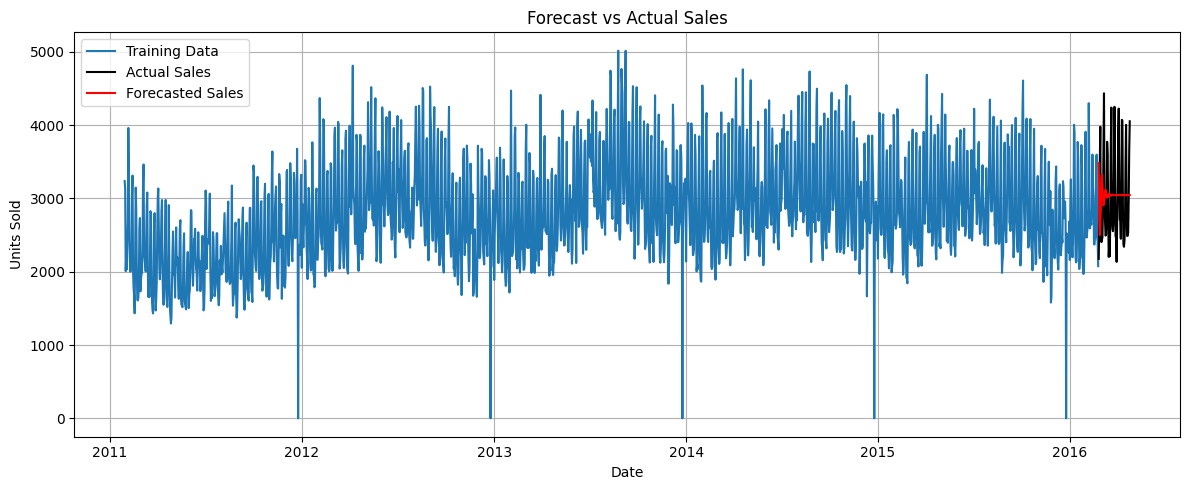

In [ ]:

plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Sales', color='black')
plt.plot(forecast.index, forecast, label='Forecasted Sales', color='red')
plt.title("Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 604.8763085153902, RMSE: 698.5839032084156


**SARIMA**

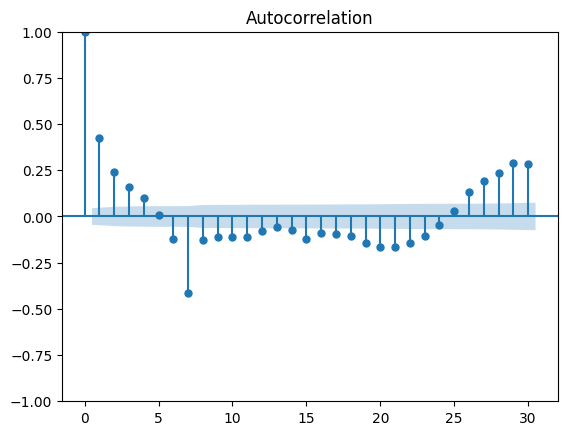

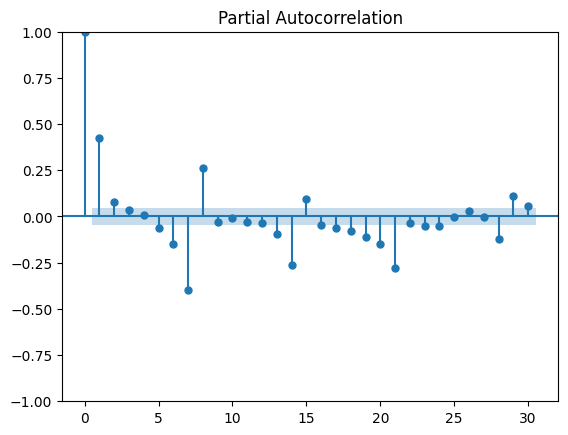

In [ ]:
# Step 6: ACF & PACF to choose seaonal ARIMA paramters(P,D,Q)
plot_acf(series_diff2, lags=30)
plot_pacf(series_diff2, lags=30)
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train,
                order=(2,1,2),
                seasonal_order=(1,1,1,7),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
results.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               FOODS   No. Observations:                 1853
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood              -13366.269
Date:                             Mon, 28 Jul 2025   AIC                          26746.538
Time:                                     13:07:56   BIC                          26785.141
Sample:                                 01-29-2011   HQIC                         26760.774
                                      - 02-24-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5073      0.153     -3.305      0.001      -0.808      -0.206
ar.L2          0.3947      0.055      7.156      0.000       0.287       0.503
ma.L1         -0.0400      0.157     -0.255      0.799      -0.347       0.267
ma.L2         -0.8717      0.146     -5.977      0.000      -1.158      -0.586
ar.S.L7        0.1155      0.044      2.605      0.009       0.029       0.202
ma.S.L7       -0.9687      0.014    -67.431      0.000      -0.997      -0.941
sigma2      1.953e+05   4773.854     40.910      0.000    1.86e+05    2.05e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             14325.70
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -1.40
Prob(H) (two-sided):                  0.39   Kurtosis:                        16.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

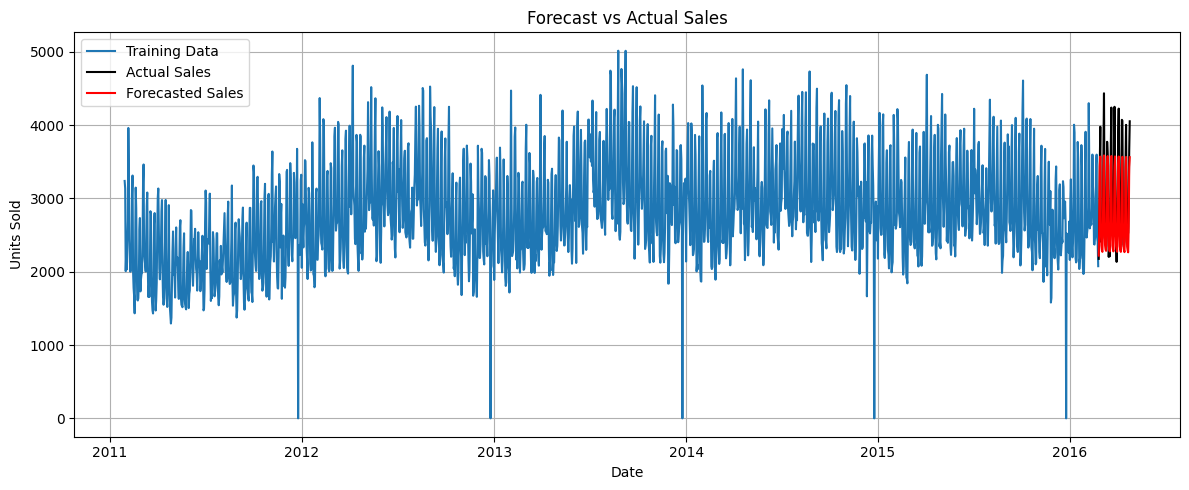

In [ ]:
forecast = results.get_forecast(steps=60)
forecast.index = test.index  # Align the forecast with test dates
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Sales', color='black')
plt.plot(forecast.index, forecast.predicted_mean, label='Forecasted Sales', color='red')
plt.title("Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
mae = mean_absolute_error(test, forecast.predicted_mean)
rmse = np.sqrt(mean_squared_error(test, forecast.predicted_mean))
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 280.29583397804566, RMSE: 348.7762557997363


**SARIMAX**

In [ ]:
exog_vars = pd.get_dummies(sales_long[['weekday', 'event_name_1']], drop_first=True)

# Add snap_CA
exog_vars['snap_CA'] = sales_long['snap_CA']

In [ ]:
exog_df = sales_long[['date', 'cat_id', 'weekday', 'event_name_1', 'snap_CA']]

# Keep only 'FOODS' category
exog_df = exog_df[exog_df['cat_id'] == 'FOODS']

# Group by date to match series
exog_df = exog_df.groupby('date').agg({
    'weekday': lambda x: x.mode()[0],   # most common weekday
    'event_name_1': lambda x: x.mode(dropna=True)[0] if not x.dropna().empty else 'None',
    'snap_CA': 'max'  # if any day has SNAP=1, keep it
}).reset_index()

# One-hot encode
exog_df_encoded = pd.get_dummies(exog_df.set_index('date'), drop_first=True)

# Final alignment
exog_df_encoded = exog_df_encoded.astype(int)
exog_df_encoded = exog_df_encoded.loc[series.index]  # same date index as series


In [ ]:
exog_test = exog_df_encoded.loc[test.index]


In [ ]:
print(test.index)
print(exog_df_encoded.index)
print(exog_test.index)

DatetimeIndex(['2016-03-26', '2016-03-27', '2016-03-28', '2016-03-29',
               '2016-03-30', '2016-03-31', '2016-04-01', '2016-04-02',
               '2016-04-03', '2016-04-04', '2016-04-05', '2016-04-06',
               '2016-04-07', '2016-04-08', '2016-04-09', '2016-04-10',
               '2016-04-11', '2016-04-12', '2016-04-13', '2016-04-14',
               '2016-04-15', '2016-04-16', '2016-04-17', '2016-04-18',
               '2016-04-19', '2016-04-20', '2016-04-21', '2016-04-22',
               '2016-04-23', '2016-04-24'],
              dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01',
               '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05',
               '2011-02-06', '2011-02-07',
               ...
               '2016-04-15', '2016-04-16', '2016-04-17', '2016-04-18',
               '2016-04-19', '2016-04-20', '2016-04-21', '2016-04-22',
               '2016-04-23', '2016-04-24'],
       

In [ ]:
exog_df_encoded.head()

,snap_CA,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,event_name_1_Christmas,event_name_1_Cinco De Mayo,event_name_1_ColumbusDay,...,event_name_1_OrthodoxEaster,event_name_1_Pesach End,event_name_1_PresidentsDay,event_name_1_Purim End,event_name_1_Ramadan starts,event_name_1_StPatricksDay,event_name_1_SuperBowl,event_name_1_Thanksgiving,event_name_1_ValentinesDay,event_name_1_VeteransDay
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-30,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-01-31,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-02-01,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2011-02-02,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
model = SARIMAX(test,
                exog=exog_test,
                order=(2,1,2),
                seasonal_order=(1,1,1,7),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(maxiter=10000)
print(results.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                      SARIMAX Results                                      
Dep. Variable:                               FOODS   No. Observations:                   60
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood                -280.545
Date:                             Mon, 28 Jul 2025   AIC                            649.090
Time:                                     13:09:00   BIC                            725.547
Sample:                                 02-25-2016   HQIC                           677.115
                                      - 04-24-2016                                         
Covariance Type:                               opg                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
snap_CA                            136.3638    155.728      0.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning:

invalid value encountered in divide



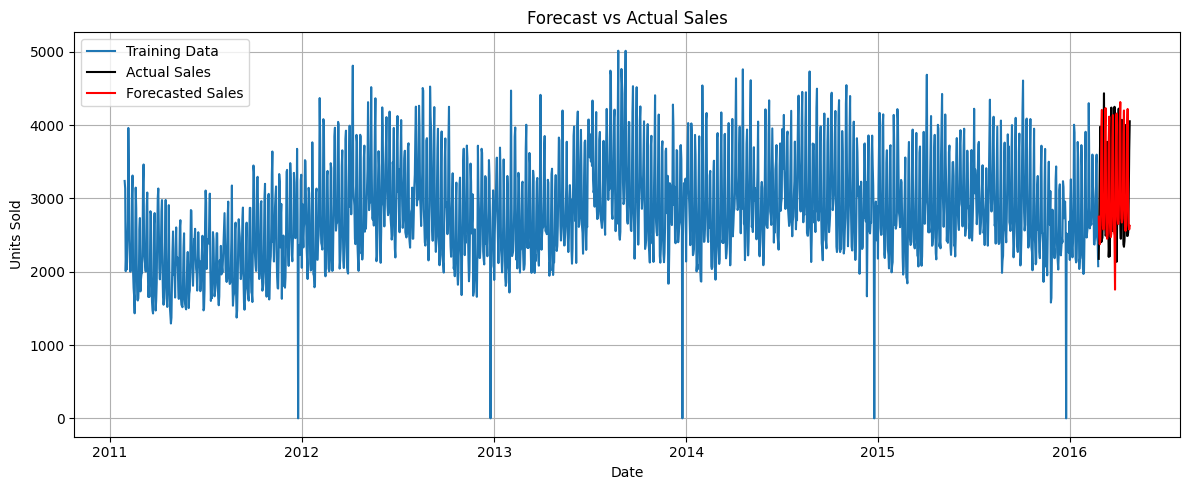

In [ ]:
forecast = results.get_forecast(steps=60,exog=exog_test)
forecast.index = test.index  # Align the forecast with test dates
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Sales', color='black')
plt.plot(forecast.index, forecast.predicted_mean, label='Forecasted Sales', color='red')
plt.title("Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
mae = mean_absolute_error(test, forecast.predicted_mean)
rmse = np.sqrt(mean_squared_error(test, forecast.predicted_mean))
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 986.8189950706113, RMSE: 1152.8358595431328


**Exponential Smoothing**

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters model (multiplicative or additive depending on data nature)
model = ExponentialSmoothing(
    series,
    trend='add',          # or 'mul' if data grows multiplicatively
    seasonal='add',       # or 'mul'
    seasonal_periods=7    # weekly seasonality for daily data
)

hw_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [ ]:
forecast_hw = hw_fit.forecast(steps=len(test))  # Forecast same number of days as test
forecast_hw.index = test.index  # Align with test dates

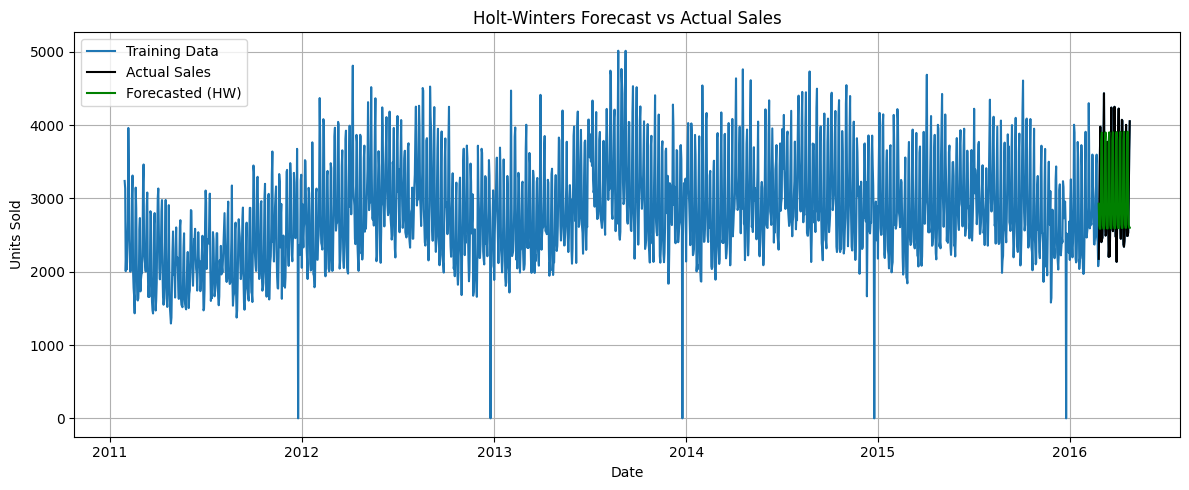

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(series.index, series, label='Training Data')
plt.plot(test.index, test, label='Actual Sales', color='black')
plt.plot(forecast_hw.index, forecast_hw, label='Forecasted (HW)', color='green')

plt.title("Holt-Winters Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
mae = mean_absolute_error(test, forecast_hw)
rmse = np.sqrt(mean_squared_error(test, forecast_hw))
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 902.18083576655, RMSE: 1055.225642133612
